In [1]:
#Import Required Libraries
import datetime
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import random
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

In [2]:
def read_train_test():
    # Test
    print('Read test file...')
    test = pd.read_csv("../data/test.csv")


    # Train
    print('Read train file...')
    train = pd.read_csv("../data/train.csv")

     # Sample Submission
    print('Read submission sample...')
    s_sample = pd.read_csv("../data/sample_submission.csv")
    
    
    print ( 'Done!')

    return train, test, s_sample

In [32]:
#Read CSVs
train, test, s_sample = read_train_test()

Read test file...
Read train file...
Read submission sample...
Done!


In [4]:
#Basic Checks
print "Dimension of train: %s, Dimension of test: %s"  % (train.shape, test.shape)

Dimension of train: (1460, 81), Dimension of test: (1459, 80)


In [13]:
#Append Train and test with Flags
train['Type']= 1 #Create a flag for Train and Test Data set
test['Type']= 0
fd = pd.concat([train,test],axis=0) #Combined both Train and Test Data set

In [29]:
#list(fd.columns.values)
fd.dtypes

1stFlrSF           int64
2ndFlrSF           int64
3SsnPorch          int64
Alley             object
BedroomAbvGr       int64
BldgType          object
BsmtCond          object
BsmtExposure      object
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtFinType1      object
BsmtFinType2      object
BsmtFullBath     float64
BsmtHalfBath     float64
BsmtQual          object
BsmtUnfSF        float64
CentralAir        object
Condition1        object
Condition2        object
Electrical        object
EnclosedPorch      int64
ExterCond         object
ExterQual         object
Exterior1st       object
Exterior2nd       object
Fence             object
FireplaceQu       object
Fireplaces         int64
Foundation        object
FullBath           int64
                  ...   
LowQualFinSF       int64
MSSubClass         int64
MSZoning          object
MasVnrArea       float64
MasVnrType        object
MiscFeature       object
MiscVal            int64
MoSold             int64
Neighborhood      object


In [25]:
#Analyze the SP of the Houses
Filter = fd.loc[fd.Type == 1,['Type','SalePrice']]
#Filter = fd.loc[fd.Type == 1,'Type':'SalePrice']

In [30]:
#Check For missing values
sum(Filter.SalePrice.isnull())

0

In [37]:
#CHECK UNIQUE VALUES
list(fd.Type.unique())

[1, 0]

In [41]:
#Use of is.null
Filter.tail().isnull()

,Type,SalePrice
1455,False,False
1456,False,False
1457,False,False
1458,False,False
1459,False,False


In [42]:
#Check for missing values in all columns
Filter.isnull().sum()

Type         0
SalePrice    0
dtype: int64

In [43]:
#Value Count
fd.Alley.value_counts(dropna = False)

NaN     2721
Grvl     120
Pave      78
Name: Alley, dtype: int64

In [ ]:
#df['BrandName'].replace(['ABC', 'AB'], 'A',inplace = True)

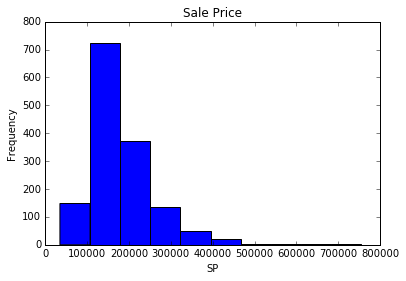

In [51]:
#histogram
plt.hist(Filter.SalePrice)
plt.title("Sale Price")
plt.xlabel("SP")
plt.ylabel("Frequency")

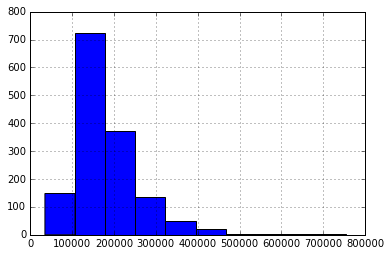

In [53]:
Filter['SalePrice'].hist()

In [54]:
#Binning
bins = [0, 200000, 300000, 400000, 1000000]
group_names = ['Low', 'Okay', 'Good', 'Great',]
categories = pd.cut(Filter['SalePrice'], bins, labels=group_names)
Filter['categories'] = pd.cut(Filter['SalePrice'], bins, labels=group_names)

In [55]:
#Check
Filter.head(10)

,Type,SalePrice,categories
0,1,208500.0,Okay
1,1,181500.0,Low
2,1,223500.0,Okay
3,1,140000.0,Low
4,1,250000.0,Okay
5,1,143000.0,Low
6,1,307000.0,Good
7,1,200000.0,Low
8,1,129900.0,Low
9,1,118000.0,Low


In [56]:
#Match with Histogram
pd.value_counts(Filter['categories'])

Low      1033
Okay      312
Good       87
Great      28
Name: categories, dtype: int64

In [5]:
train.describe()

/Applications/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,NaN,7553.500000,5.000000,5.000000,1954.000000,1967.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,NaN,9478.500000,6.000000,5.000000,1973.000000,1994.000000,NaN,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,NaN,11601.500000,7.000000,6.000000,2000.000000,2004.000000,NaN,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [10]:
#Check for above runtime warning
print train.LotFrontage.isnull().sum(), train.MasVnrArea.isnull().sum()

259 8


In [11]:
#Learn  map
train.BldgType.value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [12]:
train['BldgType_Num'] = train.BldgType.map({"1Fam":1,"TwnhsE":2})

In [14]:
train.BldgType_Num.value_counts(dropna = False)

 1.0    1220
NaN      126
 2.0     114
Name: BldgType_Num, dtype: int64

In [15]:
#Learn  Apply series method
train['BldgType_Len'] = train.BldgType.apply(len)
#Could use numpy functions as well like np.ceil/ str.split()

In [17]:
train.loc[1:10,["BldgType","BldgType_Len"]]

,BldgType,BldgType_Len
1,1Fam,4
2,1Fam,4
3,1Fam,4
4,1Fam,4
5,1Fam,4
6,1Fam,4
7,1Fam,4
8,1Fam,4
9,2fmCon,6
10,1Fam,4


In [24]:
#Apply method for dataframe
train.loc[1:100,["SalePrice","FullBath"]].apply(max, axis = 0)

SalePrice    438780
FullBath          3
dtype: int64

In [34]:
#apply map - dataframe method
train.loc[:,["SalePrice"]] = train.loc[:,["SalePrice"]].applymap(float)

In [35]:
train.loc[:,["SalePrice"]].head(5)

,SalePrice
0,208500.0
1,181500.0
2,223500.0
3,140000.0
4,250000.0
